In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import numbers
from numpy.lib.stride_tricks import as_strided
from utils_fast import conv2
import pickle
from kernelchallenge.load_data import load_data
from kernelchallenge.kmeans import SphericalKMeans
import os


### TEST KMEANS JAX ON SIMPLE DATASET

In [24]:
import jax
import jax.numpy as jnp

rng_key = jax.random.PRNGKey(0)
num_points = 200
num_clusters = 4
# Générer les centres de clusters aléatoirement
cluster_centers = 6*jax.random.normal(rng_key, (num_clusters, 2))

# Générer les points autour des centres de clusters

points_per_cluster = num_points // num_clusters
data = jnp.empty((0, 2))
for center in cluster_centers:
    cluster_data = center + jax.random.normal(rng_key, (points_per_cluster, 2))
    data = jnp.vstack((data, cluster_data))

In [25]:
normX = jnp.linalg.norm(data, ord=2, axis=-1)
normX = normX.at[normX < 1e-5].set(1e-5)
data = data / normX[:, None]

In [26]:
clustering = SphericalKMeans(nb_clusters=num_clusters, max_iter=30)
centroids, assignments = clustering.fit(data)

Spherical Kmean main loop starts
End of main loop


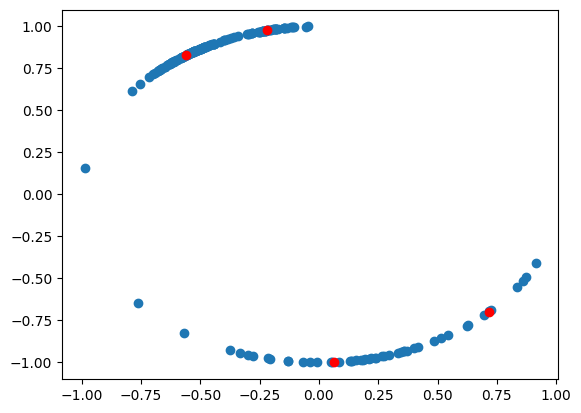

In [27]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], color='red')
plt.show()

## Utils

In [3]:
def save_pred(y_pred, outpath="output/"):
    ids = np.arange(1, 2001, dtype=int)
    arr = np.hstack((ids.reshape(-1, 1), y_pred.reshape(-1, 1)))
    arr = arr.astype(int)
    np.savetxt(
        outpath + "Yte.csv",
        arr,
        header="Id,Prediction",
        fmt="%d,%d",
        delimiter=",",
        comments="",
    )


def reshape(images, sx=32, n_channels=3):
    return images.reshape((-1, n_channels, sx, sx)).swapaxes(1, 2).swapaxes(2, 3)


def imshow(img):
    """visualize image of given vec: 1 x 3072"""
    if img.ndim < 3:
        print("ok")
        img = img.reshape((32, 32, 3), order="F")
        img = img.swapaxes(0, 1)
    for i in range(3):
        minval = img[:, :, i].min()
        maxval = img[:, :, i].max()
        if minval != maxval:
            img[:, :, i] -= minval
            img[:, :, i] *= 1.0 / (maxval - minval)
    import matplotlib.pyplot as plt

    plt.imshow(img)
    plt.axis("off")
    plt.show()


def distribution_y(filepath="data/"):
    y = np.genfromtxt(filepath + "Ytr.csv", delimiter=",", skip_header=1, dtype=int)[
        :, -1
    ]
    import matplotlib.pyplot as plt

    print(y)
    vmin = y.min()
    vmax = y.max()
    plt.hist(y, bins=np.arange(vmin - 0.5, vmax + 1.5))
    plt.show()

In [3]:
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance
    If seed is None, return the RandomState singleton used by np.random.
    If seed is an int, return a new RandomState instance seeded with seed.
    If seed is already a RandomState instance, return it.
    Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState" " instance" % seed
    )


def extract_patches_2d(image, patch_size, step=1):
    """image : nx x ny x n_channels
    output: n_patches x patch_size x patch_size x n_channels
    """
    n_channels = image.shape[-1]
    patches = extract_patches(image, (patch_size, patch_size, n_channels), step)
    return patches.reshape(-1, patch_size, patch_size, n_channels)


def extract_patches(arr, patch_shape, extraction_step):
    if isinstance(extraction_step, int):
        extraction_step = tuple([extraction_step] * arr.ndim)
    patch_strides = arr.strides
    slices = tuple(slice(None, None, st) for st in extraction_step)
    # print(slices, type(arr), arr)
    # slices
    indexing_strides = arr[slices].strides

    patch_indices_shape = (
        (np.array(arr.shape) - np.array(patch_shape)) // np.array(extraction_step)
    ) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)
    return patches


def centering_patch(patch):
    return patch - np.mean(patch, axis=(1, 2), keepdims=1)


def shape_patch(patch, threshold=1e-6):
    """patch: n_patches x size x size x n_channels
    output: n_patches x (size^2-1)n_channels
    """
    n_channels = patch.shape[-1]
    patch = patch.reshape((patch.shape[0], -1, patch.shape[-1]))
    center = int(patch.shape[1] // 2)
    patch = patch - patch[:, [center], :]
    patch = np.delete(patch, center, 1)  # remove center
    patch = patch.reshape((patch.shape[0], -1))
    # rho = np.linalg.norm(patch, axis=1)
    # rho[rho<threshold] = 0
    # # binarize the difference
    # cond = patch > 0
    # non_cond = patch <= 0
    # patch[cond] = 1.0
    # patch[non_cond] = 0.0
    return patch


def normalize_row(X, norm="l2", threshold=1e-5, return_norm=False):
    if norm == "l2":
        norms = np.linalg.norm(X, axis=1)
        norms[norms < threshold] = threshold
        X /= norms[:, np.newaxis]
    if return_norm:
        return X, norms
    return X


def kmeans(X, k, max_iter=1000, init=None):
    """normal kmeans"""
    n_samples, n_features = X.shape
    if init is None:
        perm = np.random.choice(np.arange(n_samples), k)
        centroids = X[perm]

    norm2 = np.linalg.norm(X, axis=1, keepdims=1) ** 2
    prev_obj = np.inf

    for n_iter in range(max_iter):
        dist2 = (
            np.linalg.norm(centroids, axis=1) ** 2
            - 2.0 * np.dot(X, centroids.T)
            + norm2
        )
        assign = np.argmin(dist2, axis=1)
        obj = dist2[np.unravel_index(assign, dist2.shape)].mean()
        # print dist.shape
        if (n_iter + 1) % 10 == 0:
            print(("kmeans iter %d, objective: %f" % (n_iter + 1, obj)))

        for j in range(k):
            Xj = X[assign == j]
            if Xj.shape[0] == 0:
                centroids[j] = X[np.random.randint(n_samples)]
            else:
                centroids[j] = np.mean(Xj, axis=0)

        if np.abs(prev_obj - obj) / (np.abs(obj) + 1e-20) < 1e-8:
            break
        prev_obj = obj

        # stop criteria
    return centroids, assign


def spherical_kmeans(X, k, max_iter=1000, init=None):
    """X: n x d points with unit-norm"""
    n_samples, n_features = X.shape
    if init is None:
        perm = np.random.choice(np.arange(n_samples), k)
        centroids = X[perm]

    prev_obj = np.inf
    for n_iter in range(max_iter):
        cos_sim = np.dot(X, centroids.T)
        assign = np.argmax(cos_sim, axis=1)
        obj = cos_sim[np.unravel_index(assign, cos_sim.shape)].mean()

        if (n_iter + 1) % 10 == 0:
            print(("spherical kmeans iter %d, objective: %f" % (n_iter + 1, obj)))

        for j in range(k):
            Xj = X[assign == j]
            if Xj.shape[0] == 0:
                centroids[j] = X[np.random.randint(n_samples)]
            else:
                centroids[j] = np.sum(Xj, axis=0)
                norm = np.linalg.norm(centroids[j])
                centroids[j] /= norm
        if np.abs(prev_obj - obj) / (np.abs(obj) + 1e-20) < 1e-8:
            break
        prev_obj = obj

    return centroids, assign

## Filters

In [4]:
def gaussian_filter_1d(shape, sigma):
    m = (shape - 1.0) / 2.0
    filt = np.arange(-m, m + 1)
    filt = np.exp(-np.square(filt) / (2.0 * sigma**2))
    return filt / np.sum(filt)


def conv2_gaussian(in1, shape, sigma=0.5):
    g_filter = gaussian_filter_1d(shape, sigma)
    g_filter = np.outer(g_filter, g_filter)
    return conv2(in1, g_filter)

## Model

In [5]:
LAYERTYPES = ["gradient", "patch", "shape"]


class CKN(object):
    """docstring for CKN"""

    def __init__(
        self,
        patch_sizes=[1, 2],
        subsamplings=[2, 4],
        map_dims={12, 200},
        layer_type="gradient",
    ):
        self.patch_sizes = patch_sizes
        self.subsamplings = subsamplings
        self.map_dims = map_dims
        if layer_type in LAYERTYPES:
            self.layer_type = layer_type
        else:
            raise ValueError("unknown layer type")
        self.n_layers = len(patch_sizes)

    def train(self, images):
        """
        images: n x sx x sx x channels
        """
        self.layers = []
        psis = images
        n = images.shape[0]
        for i in range(self.n_layers):
            centering = (i == 0) and (self.layer_type == "patch")
            layer = CKNLayer(
                i,
                centering,
                self.layer_type,
                self.patch_sizes[i],
                self.map_dims[i],
                self.subsamplings[i],
            )

            layer.train(psis)

            self.layers.append(layer)
            if i < self.n_layers - 1:
                for j in range(n):
                    psi = layer.forward(psis[j])
                    if j == 0:
                        out_psis = np.zeros((n,) + psi.shape)
                    out_psis[j] = psi
                psis = out_psis

    def forward(self, image, layer=None):
        """output map of the i-th layer
        layer: int < n_layers
        image: sx x sx x channels
        """
        if layer is None:
            layer = self.n_layers
        psi = image
        for i in range(layer):
            psi = self.layers[i].forward(psi)
        return psi

    def out_maps(self, images):
        n = images.shape[0]
        for i in range(n):
            output_map = self.forward(images[i])
            output_map = output_map.flatten()
            if i == 0:
                res = np.zeros((n, output_map.shape[0]))
            res[i] = output_map
        return res


def save(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)


def load(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

class CKNLayer(object):
    def __init__(self, order, centering, layer_type, patch_size, map_dim, subsampling):
        self.order = order
        self.centering = centering
        self.layer_type = layer_type
        self.patch_size = patch_size
        self.map_dim = map_dim
        self.subsampling = subsampling
        self.n_patches_per_image = 10

    def train(self, input_maps):
        if self.order == 0 and self.layer_type == "gradient":
            # no parameter training for gradient map
            return
        elif self.order == 0 and self.layer_type == "shape":
            n = input_maps.shape[0]
            for i in range(n):
                psi = input_maps[i]
                patch = extract_patches_2d(psi, self.patch_size)

                patch = shape_patch(patch)
                if i == 0:
                    n_patches_per_image = np.minimum(
                        2 * self.n_patches_per_image, patch.shape[0]
                    )
                    X = np.zeros((n * n_patches_per_image, patch.shape[1]))
                # discard patches with no variance
                idx = np.any(patch != patch[:, [0]], axis=1)
                if n_patches_per_image <= idx.sum():
                    patch = patch[idx]
                np.random.shuffle(patch)
                X[i * n_patches_per_image : (i + 1) * n_patches_per_image] = patch[
                    :n_patches_per_image
                ]
            np.random.shuffle(X)
            X = normalize_row(X, norm="l2")
            Z = spherical_kmeans(X, self.map_dim)[0]
            self.Z = Z
            self.sigma2 = 0.25
            lin_tran = gaussian_func(Z.dot(Z.T), self.sigma2)
            # svd decomposition to compute lin_tran^(-0.5)
            w, v = np.linalg.eigh(lin_tran)
            w = (w + 1e-8) ** (-0.5)
            lin_tran = v.dot(np.diag(w).dot(v.T))
            self.lin_tran = lin_tran
        else:
            n = input_maps.shape[0]
            for i in range(n):
                psi = input_maps[i]
                patch = extract_patches_2d(psi, self.patch_size)
                if self.centering:
                    patch = centering_patch(patch)
                # print patch.shape
                patch = patch.reshape((patch.shape[0], -1))
                if i == 0:
                    n_patches_per_image = np.minimum(
                        2 * self.n_patches_per_image, patch.shape[0]
                    )
                    X = np.zeros((n * n_patches_per_image, patch.shape[1]))
                # discard patches with no variance
                idx = np.any(patch != patch[:, [0]], axis=1)
                if n_patches_per_image <= idx.sum():
                    patch = patch[idx]
                np.random.shuffle(patch)
                X[i * n_patches_per_image : (i + 1) * n_patches_per_image] = patch[
                    :n_patches_per_image
                ]
            np.random.shuffle(X)
            X = normalize_row(X, norm="l2")
            Z = spherical_kmeans(X, self.map_dim)[0]
            self.Z = Z
            self.sigma2 = 0.25
            lin_tran = gaussian_func(Z.dot(Z.T), self.sigma2)
            # svd decomposition to compute lin_tran^(-0.5)
            w, v = np.linalg.eigh(lin_tran)
            w = (w + 1e-8) ** (-0.5)
            lin_tran = v.dot(np.diag(w).dot(v.T))
            self.lin_tran = lin_tran

    def forward(self, input_map):
        if self.order == 0 and self.layer_type == "gradient":
            n_channels = input_map.shape[-1]
            output_map = np.zeros(input_map.shape[:-1] + (self.map_dim * n_channels,))
            theta = np.linspace(0, 2.0 * np.pi, self.map_dim + 1)[:-1]
            delta_theta = 2.0 * np.pi / self.map_dim
            sigma2 = np.square(1 - np.cos(delta_theta)) + np.square(np.sin(delta_theta))
            self.sigma2 = sigma2
            for k in range(n_channels):
                input_map_k = input_map[:, :, k]
                dx, dy = np.gradient(input_map_k)
                rho = np.sqrt(np.square(dx) + np.square(dy))
                idx = rho > 0
                dx[idx] = dx[idx] / rho[idx]
                dy[idx] = dy[idx] / rho[idx]
                # sample theta between [0, 2*pi]
                for i in range(self.map_dim):
                    output_map[:, :, i + self.map_dim * k] = rho * gaussian_func(
                        dx * np.cos(theta[i]) + dy * np.sin(theta[i]), sigma2
                    )
        elif self.order == 0 and self.layer_type == "shape":
            # we suppose that patch_size is odd
            n_channels = input_map.shape[-1]
            patch = extract_patches_2d(input_map, self.patch_size)
            size = input_map.shape[0] - self.patch_size + 1
            patch = shape_patch(patch)
            patch, rho = normalize_row(patch, norm="l2", return_norm=True)

            output_map = gaussian_func(patch.dot(self.Z.T), self.sigma2)
            output_map = np.diag(rho).dot(output_map.dot(self.lin_tran))
            output_map = output_map.reshape((size, size, -1))
        else:
            patch = extract_patches_2d(input_map, self.patch_size)
            size = input_map.shape[0] - self.patch_size + 1
            # centering
            if self.centering:
                patch = centering_patch(patch)

            patch = patch.reshape((patch.shape[0], -1))

            patch, rho = normalize_row(patch, norm="l2", return_norm=True)
            output_map = gaussian_func(patch.dot(self.Z.T), self.sigma2)
            output_map = np.diag(rho).dot(output_map.dot(self.lin_tran))
            output_map = output_map.reshape((size, size, -1))

        # gaussian smoothing
        for i in range(output_map.shape[-1]):
            output_map[:, :, i] = conv2_gaussian(
                output_map[:, :, i],
                2 * self.subsampling + 1,
                self.subsampling / np.sqrt(2),
            )
        output_map = output_map[
            int((self.subsampling - 1) // 2) :: self.subsampling,
            int((self.subsampling - 1) // 2) :: self.subsampling,
            :,
        ]
        
        return output_map


def gaussian_func(x, sigma2):
    return np.exp(1 / sigma2 * (x - 1))

In [6]:
## CKN with SphericalKMeansJax

class CKNLayerJAX(object):
    def __init__(self, order, centering, layer_type, patch_size, map_dim, subsampling):
        self.order = order
        self.centering = centering
        self.layer_type = layer_type
        self.patch_size = patch_size
        self.map_dim = map_dim
        self.spherical_kmeans = SphericalKMeans(nb_clusters=self.map_dim, max_iter=1000)

        self.subsampling = subsampling
        self.n_patches_per_image = 10

    def train(self, input_maps):
        if self.order == 0 and self.layer_type == "gradient":
            # no parameter training for gradient map
            return
        elif self.order == 0 and self.layer_type == "shape":
            n = input_maps.shape[0]
            for i in range(n):
                psi = input_maps[i]
                patch = extract_patches_2d(psi, self.patch_size)

                patch = shape_patch(patch)
                if i == 0:
                    n_patches_per_image = np.minimum(
                        2 * self.n_patches_per_image, patch.shape[0]
                    )
                    X = np.zeros((n * n_patches_per_image, patch.shape[1]))
                # discard patches with no variance
                idx = np.any(patch != patch[:, [0]], axis=1)
                if n_patches_per_image <= idx.sum():
                    patch = patch[idx]
                np.random.shuffle(patch)
                X[i * n_patches_per_image : (i + 1) * n_patches_per_image] = patch[
                    :n_patches_per_image
                ]
            np.random.shuffle(X)

            # compute clusters
            X = normalize_row(X, norm="l2")
            Z, _ = self.spherical_kmeans.fit(X)

            self.Z = Z
            self.sigma2 = 0.25
            lin_tran = gaussian_func(Z.dot(Z.T), self.sigma2)
            # svd decomposition to compute lin_tran^(-0.5)
            w, v = np.linalg.eigh(lin_tran)
            w = (w + 1e-8) ** (-0.5)
            lin_tran = v.dot(np.diag(w).dot(v.T))
            self.lin_tran = lin_tran

        else:
            n = input_maps.shape[0]
            for i in range(n):
                psi = input_maps[i]
                patch = extract_patches_2d(psi, self.patch_size)
                if self.centering:
                    patch = centering_patch(patch)
                # print patch.shape
                patch = patch.reshape((patch.shape[0], -1))
                if i == 0:
                    n_patches_per_image = np.minimum(
                        2 * self.n_patches_per_image, patch.shape[0]
                    )
                    X = np.zeros((n * n_patches_per_image, patch.shape[1]))
                # discard patches with no variance
                idx = np.any(patch != patch[:, [0]], axis=1)
                if n_patches_per_image <= idx.sum():
                    patch = patch[idx]
                np.random.shuffle(patch)
                X[i * n_patches_per_image : (i + 1) * n_patches_per_image] = patch[
                    :n_patches_per_image
                ]
            np.random.shuffle(X)

            #
            X = normalize_row(X, norm="l2")
            Z, _ = self.spherical_kmeans.fit(X)
            self.Z = Z
            self.sigma2 = 0.25
            lin_tran = gaussian_func(Z.dot(Z.T), self.sigma2)
            # svd decomposition to compute lin_tran^(-0.5)
            w, v = np.linalg.eigh(lin_tran)
            w = (w + 1e-8) ** (-0.5)
            lin_tran = v.dot(np.diag(w).dot(v.T))
            self.lin_tran = lin_tran

    def forward(self, input_map):
        if self.order == 0 and self.layer_type == "gradient":
            n_channels = input_map.shape[-1]
            output_map = np.zeros(input_map.shape[:-1] + (self.map_dim * n_channels,))
            theta = np.linspace(0, 2.0 * np.pi, self.map_dim + 1)[:-1]
            delta_theta = 2.0 * np.pi / self.map_dim
            sigma2 = np.square(1 - np.cos(delta_theta)) + np.square(np.sin(delta_theta))
            self.sigma2 = sigma2
            for k in range(n_channels):
                input_map_k = input_map[:, :, k]
                dx, dy = np.gradient(input_map_k)
                rho = np.sqrt(np.square(dx) + np.square(dy))
                idx = rho > 0
                dx[idx] = dx[idx] / rho[idx]
                dy[idx] = dy[idx] / rho[idx]
                # sample theta between [0, 2*pi]
                for i in range(self.map_dim):
                    output_map[:, :, i + self.map_dim * k] = rho * gaussian_func(
                        dx * np.cos(theta[i]) + dy * np.sin(theta[i]), sigma2
                    )
        elif self.order == 0 and self.layer_type == "shape":
            # we suppose that patch_size is odd
            n_channels = input_map.shape[-1]
            patch = extract_patches_2d(input_map, self.patch_size)
            size = input_map.shape[0] - self.patch_size + 1
            patch = shape_patch(patch)
            patch, rho = normalize_row(patch, norm="l2", return_norm=True)

            output_map = gaussian_func(patch.dot(self.Z.T), self.sigma2)
            output_map = np.diag(rho).dot(output_map.dot(self.lin_tran))
            output_map = output_map.reshape((size, size, -1))
        else:
            patch = extract_patches_2d(input_map, self.patch_size)
            size = input_map.shape[0] - self.patch_size + 1
            # centering
            if self.centering:
                patch = centering_patch(patch)

            patch = patch.reshape((patch.shape[0], -1))

            patch, rho = normalize_row(patch, norm="l2", return_norm=True)
            output_map = gaussian_func(patch.dot(self.Z.T), self.sigma2)
            output_map = np.diag(rho).dot(output_map.dot(self.lin_tran))
            output_map = output_map.reshape((size, size, -1))

        # gaussian smoothing
        for i in range(output_map.shape[-1]):
            output_map[:, :, i] = conv2_gaussian(
                output_map[:, :, i],
                2 * self.subsampling + 1,
                self.subsampling / np.sqrt(2),
            )
        output_map = output_map[
            int((self.subsampling - 1) // 2) :: self.subsampling,
            int((self.subsampling - 1) // 2) :: self.subsampling,
            :,
        ]
        
        return output_map

In [7]:
class CKN_JAX(object):
    """docstring for CKN"""

    def __init__(
        self,
        patch_sizes=[1, 2],
        subsamplings=[2, 4],
        map_dims={12, 200},
        layer_type="gradient",
    ):
        self.patch_sizes = patch_sizes
        self.subsamplings = subsamplings
        self.map_dims = map_dims
        if layer_type in LAYERTYPES:
            self.layer_type = layer_type
        else:
            raise ValueError("unknown layer type")
        self.n_layers = len(patch_sizes)

    def train(self, images):
        """
        images: n x sx x sx x channels
        """
        self.layers = []
        psis = images
        n = images.shape[0]
        for i in range(self.n_layers):
            centering = (i == 0) and (self.layer_type == "patch")
            layer = CKNLayerJAX(
                i,
                centering,
                self.layer_type,
                self.patch_sizes[i],
                self.map_dims[i],
                self.subsamplings[i],
            )

            layer.train(psis)

            self.layers.append(layer)
            if i < self.n_layers - 1:
                for j in range(n):
                    psi = layer.forward(psis[j])
                    if j == 0:
                        out_psis = np.zeros((n,) + psi.shape)
                    out_psis[j] = psi
                psis = out_psis

    def forward(self, image, layer=None):
        """output map of the i-th layer
        layer: int < n_layers
        image: sx x sx x channels
        """
        if layer is None:
            layer = self.n_layers
        psi = image
        for i in range(layer):
            psi = self.layers[i].forward(psi)
        return psi

    def out_maps(self, images):
        n = images.shape[0]
        for i in range(n):
            output_map = self.forward(images[i])
            output_map = output_map.flatten()
            if i == 0:
                res = np.zeros((n, output_map.shape[0]))
            res[i] = output_map
        return res


## Main

In [8]:
current_path = os.getcwd()
data_path = os.path.join(current_path, "data")
# data_folder =
X, y, X_test = load_data(data_folder=data_path)
# print(X.shape, y.shape)

In [9]:
X.shape

(5000, 32, 32, 3)

In [10]:
np.random.seed(0)
train = True
save_model = False
prediction = False
save_svm_model = False


model1 = CKN([1, 2], [2, 4], [12, 200], "gradient")
modelJAX = CKN_JAX([1, 2], [2, 4], [12, 200], "gradient")
# model2 = CKN([1, 2], [2, 4], [12, 200], "patch")

# model2 = CKN([2, 2], [2, 4], [100, 200], "patch")
# model3 = CKN([3], [10], [200], "patch")
# model4 = CKN([3, 2], [2, 4], [100, 200], 'shape')
models = [model1]

In [9]:
norms = []
X_ckn_tr = []
for i, model in enumerate(models):
    if train:
        tic = time.time()
        model.train(X)
        toc = time.time()
        print(("ckn training time: %.2f s" % (toc - tic)))
        if save_model:
            save(model, "model/" + model.layer_type + "_" + str(model.n_layers))
    else:
        model = load("model/" + model.layer_type + "_" + str(model.n_layers))
        models[i] = model
        
        
    X_ckn = model.out_maps(X)
    X_ckn = X_ckn - X_ckn.mean(axis=1, keepdims=1)
    norm = np.mean(np.sqrt(np.sum(np.square(X_ckn), axis=1)))
    X_ckn = X_ckn / norm
    norms.append(norm)
    X_ckn_tr.append(X_ckn)

X_ckn_tr = np.hstack(X_ckn_tr)
del X
del X_ckn

print(X_ckn_tr.shape)

spherical kmeans iter 10, objective: 0.736805
spherical kmeans iter 20, objective: 0.736147
spherical kmeans iter 30, objective: 0.736058
spherical kmeans iter 40, objective: 0.735939
spherical kmeans iter 50, objective: 0.735849
spherical kmeans iter 60, objective: 0.735817
spherical kmeans iter 70, objective: 0.735804
spherical kmeans iter 80, objective: 0.735813
spherical kmeans iter 90, objective: 0.735761
spherical kmeans iter 100, objective: 0.735751
spherical kmeans iter 110, objective: 0.735755
spherical kmeans iter 120, objective: 0.735751
spherical kmeans iter 130, objective: 0.735738
spherical kmeans iter 140, objective: 0.735740
spherical kmeans iter 150, objective: 0.735740
spherical kmeans iter 160, objective: 0.735745
spherical kmeans iter 170, objective: 0.735737
spherical kmeans iter 180, objective: 0.735733
spherical kmeans iter 190, objective: 0.735737
ckn training time: 102.08 s
(5000, 3200)


In [11]:
X.shape

(5000, 32, 32, 3)

In [11]:
# TRAIN CKN with Kmeans JAX
tic = time.time()
modelJAX.train(X[:2500]) 
tac = time.time()
print( "ckn with kmean JAX training time : %.2f s" % (tac - tic))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Spherical Kmean main loop starts
Spherical K means at iter 10 :  mean cosine similarity 0.9235
Spherical K means at iter 20 :  mean cosine similarity 0.9240
Spherical K means at iter 30 :  mean cosine similarity 0.9242
Spherical K means at iter 40 :  mean cosine similarity 0.9243
Spherical K means at iter 50 :  mean cosine similarity 0.9243
Spherical K means at iter 60 :  mean cosine similarity 0.9243
Spherical K means at iter 70 :  mean cosine similarity 0.9244
Spherical K means at iter 80 :  mean cosine similarity 0.9244
Spherical K means at iter 90 :  mean cosine similarity 0.9244
End of main loop
ckn with kmean JAX training time : 194.45 s


In [12]:
X_ckn = modelJAX.out_maps(X[:2500])

In [13]:
X_ckn_trJAX = (X_ckn - X_ckn.mean(axis=1, keepdims=1))/X_ckn.std(axis=1, keepdims=1)

**SVM Testing**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [12]:
from sklearn.preprocessing import StandardScaler
import jax.numpy as jnp

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_ckn_tr) # Centering and scaling happen independently on each feature
X_train, X_val, y_train, y_val = train_test_split(X_tr, y, test_size=0.2, random_state=42)

C = 1
clf = svm.SVC(C=C, kernel='rbf', verbose=True)
# Train the classifier on the training data
clf.fit(X_train, y_train)
# Make predictions on the validation data
y_pred = clf.predict(X_val)
# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(f'Acc {jnp.mean( y_pred == y_val)}')

[LibSVM]*
optimization finished, #iter = 744
obj = -187.234401, rho = 0.274540
nSV = 491, nBSV = 177
*
optimization finished, #iter = 699
obj = -236.683357, rho = -0.201482
nSV = 495, nBSV = 234
*
optimization finished, #iter = 647
obj = -188.136555, rho = -0.204633
nSV = 428, nBSV = 171
*
optimization finished, #iter = 599
obj = -188.693199, rho = -0.566590
nSV = 416, nBSV = 181
*
optimization finished, #iter = 592
obj = -146.974821, rho = -0.183609
nSV = 362, nBSV = 129
*
optimization finished, #iter = 598
obj = -135.544096, rho = -0.200461
nSV = 368, nBSV = 104
*
optimization finished, #iter = 646
obj = -161.012595, rho = -0.182686
nSV = 407, nBSV = 136
*.*
optimization finished, #iter = 819
obj = -303.260125, rho = -0.316938
nSV = 603, nBSV = 326
*
optimization finished, #iter = 692
obj = -177.148999, rho = 0.121934
nSV = 449, nBSV = 167
*
optimization finished, #iter = 658
obj = -140.630517, rho = -0.497333
nSV = 406, nBSV = 110
*
optimization finished, #iter = 640
obj = -138.0623

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[3 9 5 8 6 6 9 4 6 2 2 8 3 0 7 6 1 2 7 4 1 3 5 1 6 1 0 5 7 8 2 0 6 3 6 8 5
 5 5 0 1 4 4 6 9 0 2 3 0 3 8 9 1 3 6 1 7 2 0 8 5 4 8 0 2 4 3 0 1 3 7 2 4 8
 2 5 3 5 5 6 1 9 2 9 1 6 8 8 3 2 2 6 7 8 8 4 8 0 1 9 8 4 8 9 3 6 8 1 7 5 5
 1 9 2 4 7 5 4 9 3 9 5 6 1 5 6 7 7 3 4 6 8 6 6 1 3 4 9 2 5 2 3 0 7 1 9 5 1
 1 7 1 3 2 2 7 9 4 9 6 9 3 9 7 0 6 1 9 9 4 4 9 8 9 7 4 6 1 5 0 0 2 4 6 9 5
 4 3 6 4 2 4 3 9 1 6 9 1 8 3 5 9 7 4 9 0 4 6 6 5 1 7 3 3 0 9 4 8 6 3 8 0 0
 9 2 6 5 6 0 1 3 0 3 3 0 9 9 7 8 2 5 1 2 9 2 2 8 3 9 0 0 3 8 0 1 0 5 4 9 0
 4 3 9 6 3 8 1 3 1 5 1 9 3 2 7 6 3 6 8 6 8 6 0 9 0 0 0 0 7 9 5 2 2 3 9 8 1
 5 6 1 9 4 9 9 4 1 9 5 8 6 6 1 0 2 0 0 3 6 7 4 0 5 9 6 2 1 6 2 1 4 1 8 2 6
 6 6 8 7 1 7 3 5 1 0 6 9 9 2 7 1 1 6 2 2 5 0 3 4 5 2 3 5 5 6 3 1 7 0 6 2 9
 9 7 1 7 3 4 4 3 1 0 4 3 8 8 5 0 8 6 6 1 4 7 2 9 3 9 9 4 5 1 1 4 5 8 0 1 1
 7 4 3 9 2 5 4 0 6 1 4 8 3 4 6 8 0 2 7 2 8 3 1 4 2 8 2 7 6 5 4 6 2 3 4 0 6
 4 5 6 7 8 2 0 1 5 0 4 1 1 3 9 7 7 9 0 5 6 2 8 6 3 3 8 1 9 3 9 3 6 8 2 9 9
 3 2 2 4 6 4 3 8 0 9 4 5 

In [15]:
from sklearn.preprocessing import StandardScaler
import jax.numpy as jnp

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_ckn_trJAX) # Centering and scaling happen independently on each feature
X_train, X_val, y_train, y_val = train_test_split(X_tr, y[:2500], test_size=0.2, random_state=42)

C = 1
clf = svm.SVC(C=C, kernel='rbf', verbose=True)
# Train the classifier on the training data
clf.fit(X_train, y_train)
# Make predictions on the validation data
y_pred = clf.predict(X_val)
# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(f'Acc {jnp.mean( y_pred == y_val)}')

[LibSVM]*.*
optimization finished, #iter = 457
obj = -117.926337, rho = -0.166684
nSV = 298, nBSV = 107
*.*
optimization finished, #iter = 408
obj = -131.154332, rho = 0.145172
nSV = 284, nBSV = 125
*
optimization finished, #iter = 405
obj = -98.571240, rho = 0.510263
nSV = 261, nBSV = 83
*
optimization finished, #iter = 383
obj = -108.553995, rho = 0.206697
nSV = 253, nBSV = 94
*
optimization finished, #iter = 327
obj = -84.380287, rho = 0.238763
nSV = 214, nBSV = 73
*
optimization finished, #iter = 326
obj = -81.646890, rho = -0.250887
nSV = 212, nBSV = 69
*
optimization finished, #iter = 350
obj = -84.373540, rho = 0.180922
nSV = 233, nBSV = 69
*.*
optimization finished, #iter = 445
obj = -178.210608, rho = -0.158842
nSV = 349, nBSV = 191
*.*
optimization finished, #iter = 421
obj = -108.977903, rho = 0.159505
nSV = 283, nBSV = 97
*.*
optimization finished, #iter = 441
obj = -96.277383, rho = 0.196435
nSV = 276, nBSV = 76
*
optimization finished, #iter = 392
obj = -102.270849, rho =

In [16]:
from kernelchallenge.classifiers.svm import MultiClassKernelSVM
from kernelchallenge.kernels import RBF

In [17]:
X_train.shape

(2000, 3200)

In [18]:
kernel_func = RBF(sigma=jnp.sqrt(X_train.shape[1]))
my_svm = MultiClassKernelSVM(num_classes=10, kernel_func=kernel_func, c=1)
my_svm.fit(X_train, y_train)
preds = my_svm.predict(X_val)

print('Acc', jnp.mean(preds == y_val))

Function fit took 44.34 seconds
Function predict took 1.98 seconds
Acc 0.61
